In [1]:
# Установка необходимых библиотек
!pip install pymysql sqlalchemy pandas matplotlib seaborn plotly

import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

# Настройка стилей для графиков
plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline

# Параметры подключения к базе данных
DB_HOST = '95.131.149.21'
DB_PORT = 3306
DB_USER = 'mgpu_ico_etl_13'  # или ваш пользователь
DB_PASSWORD = 'XN53jRus'
DB_NAME = 'mgpu_ico_etl_13'

# Создаем подключение к базе
try:
    engine = create_engine(f'mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
    connection = engine.connect()
    print("✅ Успешное подключение к базе данных!")
except Exception as e:
    print(f"❌ Ошибка подключения: {e}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 2.1 MB/s eta 0:00:00
✅ Успешное подключение к базе данных!


In [2]:
# Запрос для анализа доставки (используем ваш исходный запрос)
query_delivery = """
SELECT
    o.row_id,
    o.order_date,
    o.ship_date,
    o.ship_mode,
    o.sales,
    o.quantity,
    o.discount,
    o.profit,
    o.returned,
    o.state,
    o.city,
    o.product_id,
    c.product_id,
    c.customer_name,
    c.segment,
    c.country,
    c.region,
    p.category,
    p.sub_category,
    p.product_name
FROM orders o
LEFT JOIN customers c ON o.product_id = c.product_id
LEFT JOIN products p ON o.product_id = p.product_id;
"""

# Загружаем данные
df_delivery = pd.read_sql(query_delivery, connection)
print("Данные по доставке загружены. Размер:", df_delivery.shape)
print(f"Всего записей: {len(df_delivery)}")

# Рассчитываем время доставки (в днях)
df_delivery['order_date'] = pd.to_datetime(df_delivery['order_date'])
df_delivery['ship_date'] = pd.to_datetime(df_delivery['ship_date'])
df_delivery['delivery_days'] = (df_delivery['ship_date'] - df_delivery['order_date']).dt.days

# Убираем записи с некорректными датами
df_delivery = df_delivery[df_delivery['delivery_days'].notna() & (df_delivery['delivery_days'] >= 0)]

print(f"Корректных записей с доставкой: {len(df_delivery)}")
print(f"Диапазон времени доставки: от {df_delivery['delivery_days'].min()} до {df_delivery['delivery_days'].max()} дней")
df_delivery.head()

Данные по доставке загружены. Размер: (1129, 20)
Всего записей: 1129
Корректных записей с доставкой: 1129
Диапазон времени доставки: от 0 до 7 дней


,row_id,order_date,ship_date,ship_mode,sales,quantity,discount,profit,returned,state,...,product_id,product_id,customer_name,segment,country,region,category,sub_category,product_name,delivery_days
0,15,2017-11-22,2017-11-26,Standard Class,68.81,5,0.8,-123.86,NaN,Texas,...,OFF-AP-10002311,OFF-AP-10002311,Harold Pawlan,Home Office,United States,Central,Office Supplies,Appliances,Holmes Replacement Filter for HEPA Air Cleaner...,4
1,16,2017-11-22,2017-11-26,Standard Class,2.54,3,0.8,-3.82,NaN,Texas,...,OFF-BI-10000756,OFF-BI-10000756,Joe Kamberova,Consumer,United States,Central,Office Supplies,Binders,Storex DuraTech Recycled Plastic Frosted Binders,4
2,35,2019-10-19,2019-10-23,Second Class,29.47,3,0.2,9.95,NaN,Texas,...,OFF-PA-10000249,OFF-PA-10000249,Susan Gilcrest,Corporate,United States,Central,Office Supplies,Paper,Easy-staple paper,4
3,35,2019-10-19,2019-10-23,Second Class,29.47,3,0.2,9.95,NaN,Texas,...,OFF-PA-10000249,OFF-PA-10000249,Matt Abelman,Home Office,United States,Central,Office Supplies,Paper,Easy-staple paper,4
4,36,2018-12-08,2018-12-10,First Class,1097.54,7,0.2,123.47,NaN,Texas,...,TEC-PH-10004977,None,None,None,None,None,Technology,Phones,GE 30524EE4,2


In [7]:

print("ОБЩИЙ ОТЧЕТ ПО ДОСТАВКЕ")

total_orders = len(df_delivery)
avg_delivery = df_delivery['delivery_days'].mean()
min_delivery = df_delivery['delivery_days'].min()
max_delivery = df_delivery['delivery_days'].max()
median_delivery = df_delivery['delivery_days'].median()

print(f"Всего заказов с доставкой: {total_orders}")
print(f"Среднее время доставки: {avg_delivery:.2f} дней")
print(f"Минимальное время: {min_delivery:.0f} дней")
print(f"Максимальное время: {max_delivery:.0f} дней")
print(f"Среднее время: {median_delivery:.0f} дней")

# Распределение по скорости доставки
fast_delivery = (df_delivery['delivery_days'] <= 3).sum()
normal_delivery = ((df_delivery['delivery_days'] > 3) & (df_delivery['delivery_days'] <= 7)).sum()
slow_delivery = (df_delivery['delivery_days'] > 7).sum()

print(f"Быстрая доставка (≤3 дня): {fast_delivery} ({fast_delivery/total_orders*100:.1f}%)")
print(f"Нормальная доставка (4-7 дней): {normal_delivery} ({normal_delivery/total_orders*100:.1f}%)")
print(f"Медленная доставка (>7 дней): {slow_delivery} ({slow_delivery/total_orders*100:.1f}%)")


ОБЩИЙ ОТЧЕТ ПО ДОСТАВКЕ
Всего заказов с доставкой: 1129
Среднее время доставки: 3.92 дней
Минимальное время: 0 дней
Максимальное время: 7 дней
Среднее время: 4 дней
Быстрая доставка (≤3 дня): 354 (31.4%)
Нормальная доставка (4-7 дней): 775 (68.6%)
Медленная доставка (>7 дней): 0 (0.0%)


СРЕДНЕЕ ВРЕМЯ ДОСТАВКИ ПО СЕГМЕНТАМ КЛИЕНТОВ
             avg_delivery  median_delivery  min_delivery  max_delivery  order_count  return_rate
segment                                                                                         
Home Office          4.37              4.0             0             7          117        100.0
Corporate            4.01              4.0             0             7          224        100.0
Consumer             3.80              4.0             0             7          403        100.0


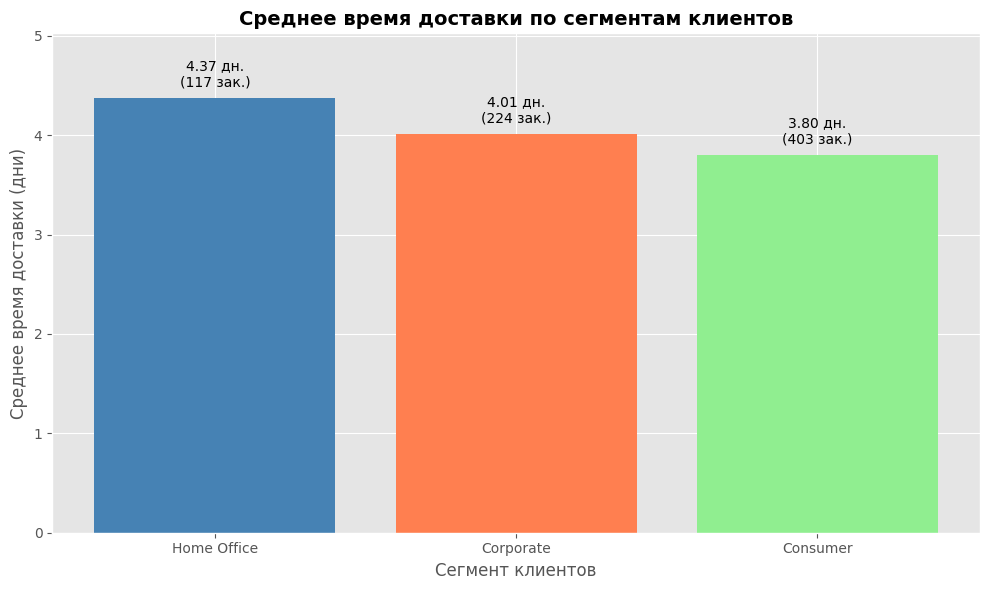

In [12]:
# Анализ по сегментам
segment_delivery = df_delivery.groupby('segment').agg({
    'delivery_days': ['mean', 'median', 'min', 'max', 'count'],
    'returned': 'mean'
}).round(2)

segment_delivery.columns = ['avg_delivery', 'median_delivery', 'min_delivery', 'max_delivery', 'order_count', 'return_rate']
segment_delivery['return_rate'] = (segment_delivery['return_rate'] * 100).round(2)
segment_delivery = segment_delivery.sort_values('avg_delivery', ascending=False)

print("СРЕДНЕЕ ВРЕМЯ ДОСТАВКИ ПО СЕГМЕНТАМ КЛИЕНТОВ")
print(segment_delivery.to_string())

# Визуализация - только первый график
plt.figure(figsize=(10, 6))

# Среднее время доставки по сегментам
segments = segment_delivery.index
avg_times = segment_delivery['avg_delivery'].values
order_counts = segment_delivery['order_count'].values

bars = plt.bar(segments, avg_times, color=['steelblue', 'coral', 'lightgreen'])
plt.xlabel('Сегмент клиентов', fontsize=12)
plt.ylabel('Среднее время доставки (дни)', fontsize=12)
plt.title('Среднее время доставки по сегментам клиентов', fontsize=14, fontweight='bold')

# Добавляем значения с автоматической подстройкой высоты
max_height = max(avg_times)
for bar, val, count in zip(bars, avg_times, order_counts):
    height = bar.get_height()
    # Поднимаем текст выше, чтобы не налезал на столбец
    text_y = height + (max_height * 0.02)  # +2% от максимальной высоты
    plt.text(bar.get_x() + bar.get_width()/2., text_y,
             f'{val:.2f} дн.\n({count} зак.)',
             ha='center', va='bottom', fontsize=10)

# Автоматически подгоняем границы графика
plt.margins(y=0.15)  # Добавляем 15% отступа сверху
plt.tight_layout()
plt.show()

СРЕДНЕЕ ВРЕМЯ ДОСТАВКИ ПО ГОРОДАМ (топ-20 по времени)
                 avg_delivery  median_delivery  order_count
city                                                       
Port Arthur              5.33              5.0            6
Irving                   5.00              5.0            9
Tyler                    5.00              5.0            5
Grand Prairie            4.93              5.0           15
Round Rock               4.71              5.0            7
Carrollton               4.62              6.0           16
College Station          4.50              4.5            6
Austin                   4.44              4.0           43
Plano                    4.41              4.0           17
Odessa                   4.40              4.0            5
Mcallen                  4.39              4.0           23
Huntsville               4.24              4.0           34
San Antonio              4.22              4.0           64
Dallas                   4.08              4.0

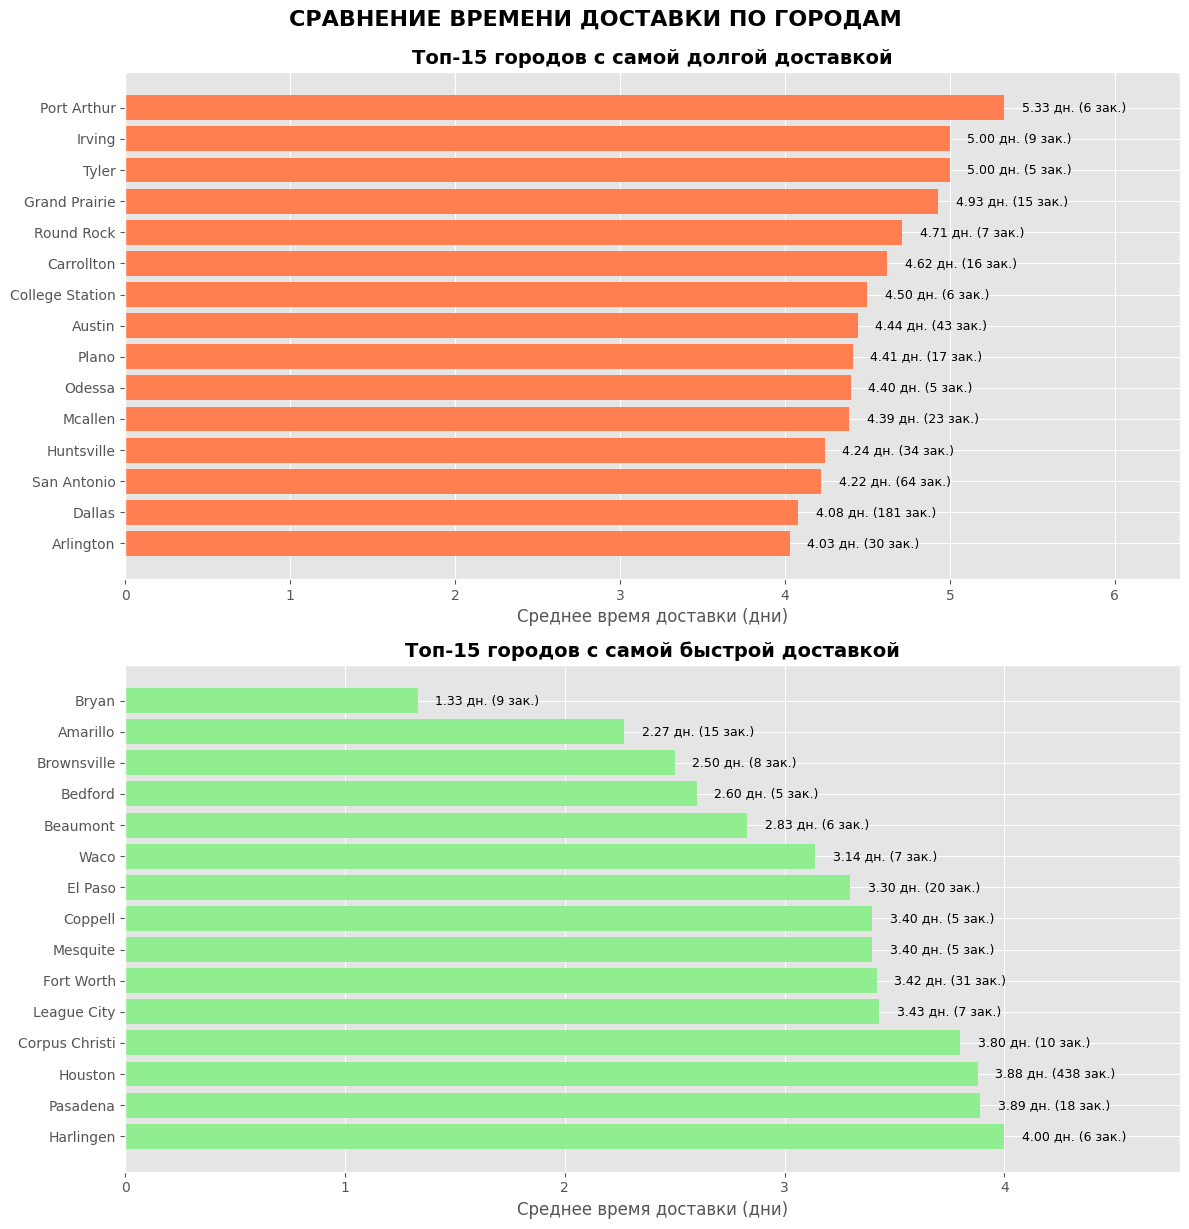

In [16]:
# Анализ по городам (только города с достаточным количеством заказов)
city_delivery = df_delivery.groupby('city').agg({
    'delivery_days': ['mean', 'median', 'min', 'max'],
    'row_id': 'count'
}).round(2)

city_delivery.columns = ['avg_delivery', 'median_delivery', 'min_delivery', 'max_delivery', 'order_count']

# Фильтруем города с минимум 5 заказами для статистической значимости
city_delivery = city_delivery[city_delivery['order_count'] >= 5].copy()
city_delivery = city_delivery.sort_values('avg_delivery', ascending=False)

print("=" * 80)
print("СРЕДНЕЕ ВРЕМЯ ДОСТАВКИ ПО ГОРОДАМ (топ-20 по времени)")
print("=" * 80)
print(city_delivery[['avg_delivery', 'median_delivery', 'order_count']].head(20).to_string())

print("\n" + "=" * 80)
print("ГОРОДА С САМОЙ БЫСТРОЙ ДОСТАВКОЙ (топ-20)")
print("=" * 80)
print(city_delivery.sort_values('avg_delivery', ascending=True)[['avg_delivery', 'median_delivery', 'order_count']].head(20).to_string())

# Визуализация - графики друг под другом
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# 1. Топ-15 городов с самой долгой доставкой (верхний график)
slowest_cities = city_delivery.sort_values('avg_delivery', ascending=False).head(15)
bars1 = axes[0].barh(slowest_cities.index, slowest_cities['avg_delivery'], color='coral')
axes[0].set_xlabel('Среднее время доставки (дни)', fontsize=12)
axes[0].set_title('Топ-15 городов с самой долгой доставкой', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Добавляем значения (только время доставки)
max_width1 = slowest_cities['avg_delivery'].max()
for bar, val, count in zip(bars1, slowest_cities['avg_delivery'], slowest_cities['order_count']):
    width = bar.get_width()
    axes[0].text(width + (max_width1 * 0.02), bar.get_y() + bar.get_height()/2,
                f'{val:.2f} дн. ({count} зак.)', va='center', fontsize=9)

# 2. Топ-15 городов с самой быстрой доставкой (нижний график)
fastest_cities = city_delivery.sort_values('avg_delivery', ascending=True).head(15)
bars2 = axes[1].barh(fastest_cities.index, fastest_cities['avg_delivery'], color='lightgreen')
axes[1].set_xlabel('Среднее время доставки (дни)', fontsize=12)
axes[1].set_title('Топ-15 городов с самой быстрой доставкой', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

# Добавляем значения (только время доставки)
max_width2 = fastest_cities['avg_delivery'].max()
for bar, val, count in zip(bars2, fastest_cities['avg_delivery'], fastest_cities['order_count']):
    width = bar.get_width()
    axes[1].text(width + (max_width2 * 0.02), bar.get_y() + bar.get_height()/2,
                f'{val:.2f} дн. ({count} зак.)', va='center', fontsize=9)

# Добавляем отступы, чтобы текст не вылезал
for ax in axes:
    ax.margins(x=0.2)  # Добавляем 20% отступа справа для текста

plt.tight_layout()
plt.suptitle('СРАВНЕНИЕ ВРЕМЕНИ ДОСТАВКИ ПО ГОРОДАМ', y=1.02, fontsize=16, fontweight='bold')
plt.show()